<a href="https://colab.research.google.com/github/duyqu-chan/Cat-Dog-Classification/blob/master/Copy_of_CatDogClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat-Dog Classification Homework


First, we will get the raw data from a GitHub[ repo](https://github.com/ardamavi/Dog-Cat-Classifier/tree/master/Data/npy_train_data).

In [0]:
# X:
! wget https://github.com/ardamavi/Dog-Cat-Classifier/blob/master/Data/npy_train_data/X.npy?raw=true -O X.npy
  
# Y:
! wget https://github.com/ardamavi/Dog-Cat-Classifier/blob/master/Data/npy_train_data/Y.npy?raw=true -O Y.npy

--2019-05-23 10:35:01--  https://github.com/ardamavi/Dog-Cat-Classifier/blob/master/Data/npy_train_data/X.npy?raw=true
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ardamavi/Dog-Cat-Classifier/raw/master/Data/npy_train_data/X.npy [following]
--2019-05-23 10:35:02--  https://github.com/ardamavi/Dog-Cat-Classifier/raw/master/Data/npy_train_data/X.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ardamavi/Dog-Cat-Classifier/master/Data/npy_train_data/X.npy [following]
--2019-05-23 10:35:03--  https://media.githubusercontent.com/media/ardamavi/Dog-Cat-Classifier/master/Data/npy_train_data/X.npy
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media

Now, we have the following files:

In [0]:
!ls

Dog-Cat-Classifier  drive  sample_data	X.npy  Y.npy


We can read the data as follows:

In [0]:
import numpy as np

X = np.load('X.npy')
Y = np.load('Y.npy')

## About the Dataset

There are 1400 images belonging to two classes (cat or dog). The resolution is 64x64 and there are 3 color channels for red, green and blue.

In [0]:
print('X Shape:', X.shape)
print('Y Shape:', Y.shape)

X Shape: (1400, 64, 64, 3)
Y Shape: (1400, 2)


Hopefully, we have uniform categorical distribution.

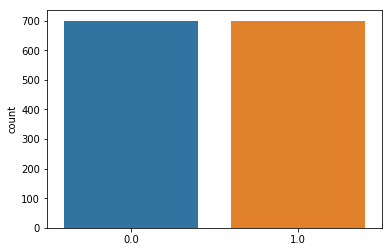

In [0]:
import seaborn as sns
category = Y[:,0]
sns.countplot(category)

Let's visualize 76th sample.

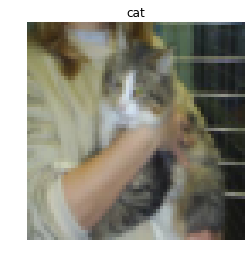

In [0]:
import matplotlib
import matplotlib.pyplot as plt

sample_index = 76
%matplotlib inline
img = X[sample_index]/255 #normalize the image vector into 0-255 range


#decode label
if (labelArr == [1, 0]).all():
  label = "cat"
else:
  label = "dog"
  
plt.imshow(img, interpolation='nearest')
plt.axis("off")
plt.title(label)
plt.show()

## Pre-processing

Normalization

In [0]:
X /= 255.

## Train/Test Split

We reserved 75% of the data for training and 25% for validation. To better represent test data with training data stratified sampling is used.

In [0]:
from sklearn.model_selection import train_test_split

X, X_test, Y, Y_test = train_test_split(X,Y,test_size = 0.10,stratify=Y)

## Building the Model

In [0]:
# parameters to be optimized
inputShape = (64, 64, 3)
classNum = Y.shape[1]
k1 = 3 # Kernel dimension of the 1st layer
f1 = 16 # the number of output filters in the 1st layer
k2 = 3 # Kernel dimension of the 2nd layer
f2 = 32 # the number of output filters in the 2nd layer
k3 = 5 # Kernel dimension of the 3rd layer
f3 = 64 # the number of output filters in the 3rd layer
k4 = 5 # Kernel dimension of the 3rd layer
f4 = 128 # the number of output filters in the 3rd layer
d_conv = 0.5 # dropout rate of the convolutional layers
d_dense = 0.5 # dropout rate of the ANN layer
DR = 0.01 # decay rate of the optimizer
Epochs = 30 # 
batchSize = 8 # number of randomly taken samples from features and labels to feed into each epoch until an epoch limit is reached.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  BatchNormalization, Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Conv2D(filters=f1,kernel_size=(k1,k1),padding='Same',kernel_initializer="TruncatedNormal",activation ='relu', 
                 input_shape = inputShape))
model.add(BatchNormalization())
model.add(Conv2D(filters=f2,kernel_size=(k2,k2),padding='Same',kernel_initializer="TruncatedNormal",activation ='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(d_conv))


model.add(Conv2D(filters = f3, kernel_size = (k3,k3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = f4, kernel_size = (k4,k4),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(d_conv))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(d_dense))
model.add(Dense(classNum, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       204928    
__________

## Compilation

In [0]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(), #instead of annealer decay = DR can be set, too
              metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

## Data Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X)

## Training

In [0]:
# Fit the model
history = model.fit_generator(datagen.flow(X,Y, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_test,Y_test),
                              verbose = 1, steps_per_epoch=X.shape[0] // batchSize
                              , callbacks=[annealer])

Epoch 1/30
157/157 [==============================] - 7s 47ms/step - loss: 7.9910 - acc: 0.4992 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 2/30
157/157 [==============================] - 6s 35ms/step - loss: 7.9769 - acc: 0.5024 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 3/30
157/157 [==============================] - 6s 35ms/step - loss: 7.9513 - acc: 0.5040 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 4/30
157/157 [==============================] - 5s 35ms/step - loss: 8.0917 - acc: 0.4952 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 5/30
157/157 [==============================] - 5s 35ms/step - loss: 7.9420 - acc: 0.5016 - val_loss: 8.0270 - val_acc: 0.4929
Epoch 6/30
157/157 [==============================] - 6s 35ms/step - loss: 7.8584 - acc: 0.5040 - val_loss: 8.4731 - val_acc: 0.4714
Epoch 7/30
157/157 [==============================] - 6s 35ms/step - loss: 7.8759 - acc: 0.5040 - val_loss: 8.8166 - val_acc: 0.4500
Epoch 8/30
157/157 [==============================] - 5s 35ms/step - 

## Training and Validation Performance

In [0]:
valLoss, valAcc = model.evaluate(X_test, Y_test, verbose=0)
trainLoss, trainAcc = model.evaluate(X, Y, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

Validation Loss: 7.612331, Validation Accuracy: 0.521429
Train Loss: 7.479846, Train Accuracy: 0.531746


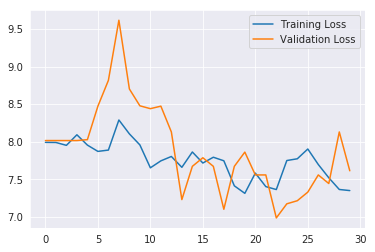

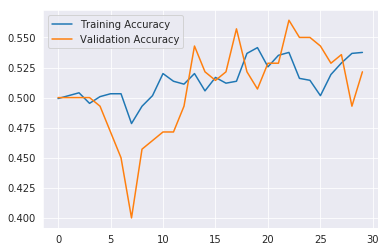

In [0]:
sns.set_style("darkgrid")
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()

## Confusion Matrix

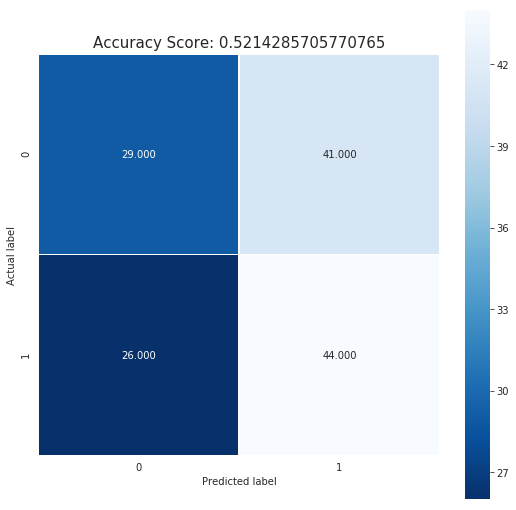

In [0]:
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test) # Predict values of the test set
testLoss, testAcc = model.evaluate(X_test, Y_test, verbose=0)
pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test = to_categorical(Y_test, num_classes = classNum) 
y_test1hot = np.argmax(Y_test, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix
#print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


testLoss, testAcc = model.evaluate(X_test, Y_test, verbose=0)

all_sample_title = 'Accuracy Score: {0}'.format(testAcc)
plt.title(all_sample_title, size = 15);

In [0]:
#from google.colab import drive
#drive.mount('/content/drive/')
#!git clone https://github.com/ardamavi/Dog-Cat-Classifier.git

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Cloning into 'Dog-Cat-Classifier'...
remote: Enumerating objects: 1654, done.
remote: Total 1654 (delta 0), reused 0 (delta 0), pack-reused 1654
Receiving objects: 100% (1654/1654), 34.83 MiB | 8.74 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [0]:
!ls
!cd Dog-Cat-Classifier/
!ls

Dog-Cat-Classifier  drive  sample_data	X.npy  Y.npy
Dog-Cat-Classifier  drive  sample_data	X.npy  Y.npy


In [0]:
!cd Dog-Cat-Classifier/

In [0]:
!ls

Dog-Cat-Classifier  drive  sample_data	X.npy  Y.npy
